In [175]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-detection/true.csv
/kaggle/input/fake-news-detection/fake.csv


# Load the dataset

In [176]:
true = pd.read_csv('/kaggle/input/fake-news-detection/true.csv')

In [177]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [178]:
true.shape

(21417, 4)

In [179]:
fake = pd.read_csv('/kaggle/input/fake-news-detection/fake.csv')

In [180]:
fake.shape

(23481, 4)

In [181]:
true['label'] = 1
fake['label'] = 0

In [182]:
# Use the the first 5000 data of true and fake dataset for building the model.
frames = [true.loc[:5000][:], fake.loc[:5000][:]]

In [183]:
df = pd.concat(frames)

In [184]:
df.shape

(10002, 5)

In [185]:
X = df. drop('label', axis=1)
y = df['label']

In [186]:
df = df.dropna()
df2 = df.copy()

In [187]:
df2.reset_index(inplace=True)
df2.head()

,index,title,text,subject,date,label
0,0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


# Data Preprocessing

In [188]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [189]:
import re
import nltk
nltk.download('stopwords')

corpus = []
for i in range(0, len(df2)):
    review = re.sub('[^a-zA-Z]', ' ', df2['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [190]:
# TFidf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_v = TfidfVectorizer(max_features=5000, ngram_range=(1,3))

In [191]:
X = tfidf_v.fit_transform(corpus).toarray()
y = df2['label']

In [192]:
# Divide the dataset into Train and Test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Model building - Passive Aggresive Classifier

In [193]:
from sklearn.linear_model import PassiveAggressiveClassifier
classifier = PassiveAggressiveClassifier(max_iter=1000)

In [194]:
from sklearn import metrics
import numpy as np
import itertools

classifier.fit(X_train, y_train)

pred = classifier.predict(X_test)

score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.998


In [195]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


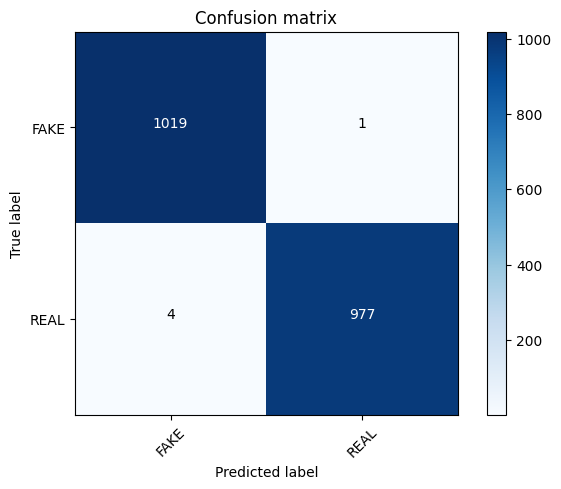

In [196]:
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'])

# Validate on an unseen datapoint

In [197]:
review = re.sub('[^a-zA-Z]', ' ', fake['text'][13070])
review = review.lower()
review = review.split()
    
review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
review = ' '.join(review)
review

'mani c word hillari compet one ouch'

In [198]:
val = tfidf_v.transform([review]).toarray()

In [199]:
classifier.predict(val)

array([0])

# Save model and vectorizer

In [200]:
import pickle
pickle.dump(classifier, open('model2.pkl', 'wb'))
pickle.dump(tfidf_v, open('tfidfvect2.pkl', 'wb'))

# Load model and vectorizer to predict the previous datapoint

In [201]:
joblib_model = pickle.load(open('model2.pkl', 'rb'))
joblib_vect = pickle.load(open('tfidfvect2.pkl', 'rb'))
val_pkl = joblib_vect.transform([review]).toarray()
test_pred = joblib_model.predict(val_pkl)

if test_pred == 0:
    print("Fake News!")
else:
    print("Real News")

Fake News!
